<a href="https://colab.research.google.com/github/saeid-6780/Big-Data/blob/main/BD_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 47.4 MB/s 


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:

!pip install gdown
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1IDIE0Om9Wp59v4Ekjp-Naqtd_HtkLRfY

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1IDIE0Om9Wp59v4Ekjp-Naqtd_HtkLRfY
To: /content/Copy of data.csv
100% 32.7M/32.7M [00:00<00:00, 106MB/s] 


In [23]:
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import col,isnan, when, count

sc = SparkContext.getOrCreate();('local')
spark = SparkSession(sc)
raw_data = spark.read.options(inferSchema='True',header='True').csv("/content/Copy of data.csv")
#raw_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in raw_data.columns]).show()
for col in raw_data.columns:
  print(col, "\t", "with null values: ", raw_data.filter(raw_data[col].isNull()).count())
raw_data.show()


customerID 	 with null values:  253
gender 	 with null values:  235
SeniorCitizen 	 with null values:  266
Partner 	 with null values:  225
Dependents 	 with null values:  242
tenure 	 with null values:  225
PhoneService 	 with null values:  269
MultipleLines 	 with null values:  263
InternetService 	 with null values:  230
OnlineSecurity 	 with null values:  230
OnlineBackup 	 with null values:  243
DeviceProtection 	 with null values:  254
TechSupport 	 with null values:  264
StreamingTV 	 with null values:  249
StreamingMovies 	 with null values:  219
Contract 	 with null values:  230
PaperlessBilling 	 with null values:  257
PaymentMethod 	 with null values:  246
MonthlyCharges 	 with null values:  243
TotalCharges 	 with null values:  251
Label 	 with null values:  208
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------

In [24]:
for col in raw_data.columns:
  if(col != "customerID" and col !="tenure" and col!="MonthlyCharges" and col!="TotalCharges"):
    distinct_cat=raw_data.select(col).distinct().rdd.map(lambda r: r[0]).collect()
    print(col , "values: ", distinct_cat)

gender values:  [None, 'Female', 'Male']
SeniorCitizen values:  [0.0, None, 1.0, 14.0, 17.0]
Partner values:  [None, 'No', 'Yes']
Dependents values:  [None, 'No', 'Yes']
PhoneService values:  [None, 'No', 'Yes']
MultipleLines values:  ['No phone service', None, 'No', 'Yes']
InternetService values:  [None, 'Fiber optic', 'No', 'DSL']
OnlineSecurity values:  [None, 'No', 'Yes', 'No internet service']
OnlineBackup values:  [None, 'No', 'Yes', 'No internet service']
DeviceProtection values:  [None, 'No', 'Yes', 'No internet service']
TechSupport values:  [None, 'No', 'Yes', 'No internet service']
StreamingTV values:  [None, 'No', 'Yes', 'No internet service']
StreamingMovies values:  [None, 'No', 'Yes', 'No internet service']
Contract values:  ['Month-to-month', None, 'One year', 'Two year']
PaperlessBilling values:  [None, 'No', 'Yes']
PaymentMethod values:  ['Credit card (automatic)', None, 'Mailed check', 'Bank transfer (automatic)', 'Electronic check']
Label values:  [None, 'No', 'Yes'

In [28]:
print(raw_data.count())
raw_data_withoutMV=raw_data.na.drop()
print(raw_data_withoutMV.count())

229990
229190


In [93]:
from pyspark.sql.functions import when, lit

def mode_of_pyspark_columns(df, cat_col_list):
    col_with_mode=[]
    for col in cat_col_list:
        #Filter null
        df = df.filter(df[col].isNull()==False)
        #Find unique_values_with_count
        unique_classes = df.select(col).distinct().rdd.map(lambda x: x[0]).collect()
        unique_values_with_count=[]
        for uc in unique_classes:
             unique_values_with_count.append([uc, df.filter(df[col]==uc).count()])
        #sort unique values w.r.t their count values
        sorted_unique_values_with_count= sorted(unique_values_with_count, key = lambda x: x[1], reverse =True)
        
        col_with_mode.append([col, sorted_unique_values_with_count[0][0]])
    return col_with_mode

def fill_missing_with_mode(df, cat_col_list):
    col_with_mode =mode_of_pyspark_columns(df, cat_col_list)
    
    for col, mode in col_with_mode:
        df = df.withColumn(col, when(df[col].isNull()==True, 
        lit(mode)).otherwise(df[col]))
        
    return df

cat_col_list=['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Label']
FEdataset = fill_missing_with_mode(raw_data, cat_col_list)
for col in FEdataset.columns:
  print(col, "\t", "with null values: ", FEdataset.filter(FEdataset[col].isNull()).count())

customerID 	 with null values:  253
gender 	 with null values:  0
SeniorCitizen 	 with null values:  266
Partner 	 with null values:  0
Dependents 	 with null values:  0
tenure 	 with null values:  225
PhoneService 	 with null values:  0
MultipleLines 	 with null values:  0
InternetService 	 with null values:  0
OnlineSecurity 	 with null values:  0
OnlineBackup 	 with null values:  0
DeviceProtection 	 with null values:  0
TechSupport 	 with null values:  0
StreamingTV 	 with null values:  0
StreamingMovies 	 with null values:  0
Contract 	 with null values:  0
PaperlessBilling 	 with null values:  0
PaymentMethod 	 with null values:  0
MonthlyCharges 	 with null values:  243
TotalCharges 	 with null values:  251
Label 	 with null values:  0


In [94]:
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import col, trim, lower

meanimputer = Imputer(
    inputCols=['tenure','MonthlyCharges','TotalCharges'], 
    outputCols= ['tenure','MonthlyCharges','TotalCharges']
    ).setStrategy("mean")
FEdataset = meanimputer.fit(FEdataset).transform(FEdataset)
FEdataset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in FEdataset.columns]).show()
modeimputer = Imputer(
    inputCols=['SeniorCitizen'], 
    outputCols= ['SeniorCitizen']
    ).setStrategy("mode")
FEdataset = modeimputer.fit(FEdataset).transform(FEdataset)
FEdataset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in FEdataset.columns]).show()
for col in FEdataset.columns:
  print(col, "\t", "with null values: ", FEdataset.filter(FEdataset[col].isNull()).count())

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|     0|          266|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [97]:
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import col, trim, lower
def highDependents_column(Partner,Dependents):
    if (Partner=='Yes' and Dependents=='Yes'):
        highDependents='Yes' 
    else:
        highDependents='No' 
    return highDependents
highDependents_column_UDF = udf( highDependents_column) 
dataset=FEdataset.withColumn("highDependents", highDependents_column_UDF(col("Partner"),col("Dependents")))
dataset.show()

dataset.select(dataset["Partner"],dataset["Dependents"],dataset["highDependents"]).show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|highDependents|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------+
|5331-RGMTT|  Ma

In [98]:
def Cautious_column(OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport):
    CautiousScore=0
    if (OnlineSecurity=='Yes' ):
        CautiousScore +=1
    if (OnlineBackup=='Yes' ):
        CautiousScore +=1
    if (DeviceProtection=='Yes' ):
        CautiousScore +=1
    if (TechSupport=='Yes' ):
        CautiousScore +=1
    Cautious='No'
    if (CautiousScore>2):
        Cautious='Yes'
    return Cautious
Cautious_column_UDF = udf( Cautious_column)

dataset=dataset.withColumn("Cautious", Cautious_column_UDF(col("OnlineSecurity"),col("OnlineBackup"),col("DeviceProtection"),col("TechSupport")))
dataset.select(dataset["OnlineSecurity"],dataset["OnlineBackup"],dataset["DeviceProtection"],dataset["TechSupport"],dataset["Cautious"]).show()


+-------------------+-------------------+-------------------+-------------------+--------+
|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|Cautious|
+-------------------+-------------------+-------------------+-------------------+--------+
|                 No|                 No|                Yes|                 No|      No|
|                 No|                 No|                Yes|                Yes|      No|
|                Yes|                Yes|                Yes|                Yes|     Yes|
|                 No|                Yes|                 No|                 No|      No|
|                 No|                Yes|                Yes|                Yes|     Yes|
|                Yes|                 No|                Yes|                Yes|     Yes|
|No internet service|No internet service|No internet service|No internet service|      No|
|                 No|                Yes|                Yes|                Yes|     Yes|

In [99]:
def FullTech_column(PhoneService,InternetService,StreamingTV,StreamingMovies):
    FullTech='No'
    if (PhoneService=='Yes' and  InternetService!='No' and StreamingTV=='Yes' and StreamingMovies=='Yes'):
        FullTech ='Yes'
    return FullTech
FullTech_column_UDF = udf( FullTech_column)

dataset=dataset.withColumn("FullTech", FullTech_column_UDF(col("PhoneService"),col("InternetService"),col("StreamingTV"),col("StreamingMovies")))
dataset.select(dataset["PhoneService"],dataset["InternetService"],dataset["StreamingTV"],dataset["StreamingMovies"],dataset["FullTech"]).show()


+------------+---------------+-------------------+-------------------+--------+
|PhoneService|InternetService|        StreamingTV|    StreamingMovies|FullTech|
+------------+---------------+-------------------+-------------------+--------+
|         Yes|    Fiber optic|                Yes|                Yes|     Yes|
|         Yes|    Fiber optic|                Yes|                 No|      No|
|         Yes|            DSL|                Yes|                 No|      No|
|         Yes|            DSL|                 No|                 No|      No|
|         Yes|    Fiber optic|                Yes|                Yes|     Yes|
|         Yes|    Fiber optic|                Yes|                Yes|     Yes|
|         Yes|             No|No internet service|No internet service|      No|
|          No|            DSL|                Yes|                Yes|      No|
|         Yes|             No|No internet service|No internet service|      No|
|         Yes|    Fiber optic|          

In [100]:
dataset=dataset.drop('ContractInMonth')
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, trim, lower
def ContractInMonth_column(Contract):
    if(Contract=='Two year'):
        ContractInMonth=24
    elif(Contract=='One year'):
        ContractInMonth=12
    else:
        ContractInMonth=1
    return int(ContractInMonth)
ContractInMonth_column_UDF = udf( ContractInMonth_column, IntegerType())
dataset=dataset.withColumn("ContractInMonth", ContractInMonth_column_UDF(col("Contract")))
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)
 |-- highDependents: string (nullable = true)
 |-- Cautious: string (nullable = true

In [11]:
print(dataset.columns)
for col in dataset.columns:
  if(col != "customerID" and col !="tenure" and col!="MonthlyCharges" and col!="TotalCharges"):
    distinct_cat=dataset.select(col).distinct().rdd.map(lambda r: r[0]).collect()
    print(col , "values: ", distinct_cat)

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Label', 'highDependents', 'Cautious', 'FullTech', 'ContractInMonth']
gender values:  ['Female', 'Male']
SeniorCitizen values:  [0.0, 1.0, 14.0, 17.0]
Partner values:  ['No', 'Yes']
Dependents values:  ['No', 'Yes']
PhoneService values:  ['No', 'Yes']
MultipleLines values:  ['No phone service', 'No', 'Yes']
InternetService values:  ['Fiber optic', 'No', 'DSL']
OnlineSecurity values:  ['No', 'Yes', 'No internet service']
OnlineBackup values:  ['No', 'Yes', 'No internet service']
DeviceProtection values:  ['No', 'Yes', 'No internet service']
TechSupport values:  ['No', 'Yes', 'No internet service']
StreamingTV values:  ['No', 'Yes', 'No internet service']
StreamingMovies values:

In [101]:
from pyspark.ml.feature import StringIndexer
all_cat_col_list=['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','highDependents','Cautious','FullTech']
for col in all_cat_col_list:
  outCol='i'+col
  dataset=dataset.drop(outCol)
  dataset = StringIndexer(inputCol=col,outputCol=outCol,handleInvalid='keep').fit(dataset).transform(dataset)

dataset.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------+--------+--------+---------------+-------+--------+-----------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+---------+-----------------+--------------+---------------+---------+---------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|highDependents|Cautious|FullTech|ContractInMonth|igender|iPartner|iDependents|iPh

In [102]:

dataset = StringIndexer(inputCol='Label',outputCol='iLabel',handleInvalid='keep').fit(dataset).transform(dataset)
dataset.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------+--------+--------+---------------+-------+--------+-----------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+---------+-----------------+--------------+---------------+---------+---------+------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|highDependents|Cautious|FullTech|ContractInMonth|igender|iPartner|iDepende

In [110]:
dataset=dataset.drop('gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','highDependents','Cautious','FullTech','Label')

dataset.show()

+----------+-------------+------+--------------+------------+---------------+-------+--------+-----------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+---------+-----------------+--------------+---------------+---------+---------+------+
|customerID|SeniorCitizen|tenure|MonthlyCharges|TotalCharges|ContractInMonth|igender|iPartner|iDependents|iPhoneService|iMultipleLines|iInternetService|iOnlineSecurity|iOnlineBackup|iDeviceProtection|iTechSupport|iStreamingTV|iStreamingMovies|iContract|iPaperlessBilling|iPaymentMethod|ihighDependents|iCautious|iFullTech|iLabel|
+----------+-------------+------+--------------+------------+---------------+-------+--------+-----------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+---------+-----------------+--------------+---------------+---------+---------+------+
|5331-RGMT

In [83]:

from pyspark.ml.feature import VectorAssembler
all_features=['SeniorCitizen','tenure','MonthlyCharges','TotalCharges','ContractInMonth','igender','iPartner','iDependents','iPhoneService','iMultipleLines','iInternetService','iOnlineSecurity','iOnlineBackup','iDeviceProtection','iTechSupport','iStreamingTV','iStreamingMovies','iContract','iPaperlessBilling','iPaymentMethod','ihighDependents','iCautious','iFullTech']
all_features_assembler = VectorAssembler(inputCols=all_features, outputCol='AllFeatures')
af_transformed_dataset = all_features_assembler.transform(dataset)
af_transformed_dataset.select(af_transformed_dataset["AllFeatures"]).show(truncate=False)


+--------------------------------------------------------------------------------------------------------+
|AllFeatures                                                                                             |
+--------------------------------------------------------------------------------------------------------+
|(23,[0,1,2,3,4,11,12,14,17,19,22],[1.0,54.0,99.05,5295.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                  |
|(23,[1,2,3,4,11,12,16,18,19],[37.0,94.3,3460.95,24.0,1.0,1.0,1.0,1.0,3.0])                              |
|(23,[0,1,2,3,4,9,10,16,18,21],[1.0,72.0,74.4,5360.75,24.0,1.0,1.0,1.0,1.0,1.0])                         |
|(23,[1,2,3,4,9,10,11,13,14,15,16,17],[8.0,49.55,393.45,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])            |
|(23,[0,1,2,3,4,7,11,17,19,20,21,22],[1.0,66.0,108.45,7076.35,12.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0])         |
|(23,[1,2,3,4,5,7,12,18,19,20,21,22],[72.0,107.45,7576.7,24.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0])          |
|(23,[1,2,3,4,7,10,11,12,13,14,15,16,

In [62]:
from pyspark.ml.stat import Correlation
pearsonCorrOnFEdataset = Correlation.corr(af_transformed_dataset, 'AllFeatures', 'pearson').collect()[0][0]
print(str(pearsonCorrOnFEdataset))
af_transformed_dataset.show(truncate=0)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


DenseMatrix([[ 1.00000000e+00,  2.19843834e-02, -2.12519570e-04,
               7.04876234e-02, -7.29700281e-02, -1.29094003e-02,
              -4.36918455e-03, -9.57397960e-02, -4.50762537e-03,
              -4.73911416e-02, -1.11620345e-01, -3.58329775e-02,
              -6.02669441e-02, -4.00309111e-02, -1.42234477e-02,
              -7.21402763e-02, -6.55293653e-02,  5.59644165e-02,
              -5.15962274e-02,  6.07553124e-03, -8.08842759e-02,
              -2.03275030e-02,  5.25887850e-02],
             [ 2.19843834e-02,  1.00000000e+00,  1.50840444e-02,
               3.55201299e-01,  3.20563575e-01, -7.42275087e-03,
              -1.42150748e-01,  1.36529470e-02,  6.72260788e-03,
              -1.02924610e-01, -3.99258977e-03, -7.78994093e-02,
              -9.19304969e-02, -8.66608005e-02, -9.47695563e-02,
              -6.05974448e-02, -6.71895492e-02, -1.76577701e-01,
              -1.01906411e-02, -1.62104538e-01,  3.82808679e-02,
               1.76690334e-01,  9.8707922

[[ 1.00000000e+00  2.19843834e-02 -2.12519570e-04  7.04876234e-02
  -7.29700281e-02 -1.29094003e-02 -4.36918455e-03 -9.57397960e-02
  -4.50762537e-03 -4.73911416e-02 -1.11620345e-01 -3.58329775e-02
  -6.02669441e-02 -4.00309111e-02 -1.42234477e-02 -7.21402763e-02
  -6.55293653e-02  5.59644165e-02 -5.15962274e-02  6.07553124e-03
  -8.08842759e-02 -2.03275030e-02  5.25887850e-02]
 [ 2.19843834e-02  1.00000000e+00  1.50840444e-02  3.55201299e-01
   3.20563575e-01 -7.42275087e-03 -1.42150748e-01  1.36529470e-02
   6.72260788e-03 -1.02924610e-01 -3.99258977e-03 -7.78994093e-02
  -9.19304969e-02 -8.66608005e-02 -9.47695563e-02 -6.05974448e-02
  -6.71895492e-02 -1.76577701e-01 -1.01906411e-02 -1.62104538e-01
   3.82808679e-02  1.76690334e-01  9.87079227e-02]
 [-2.12519570e-04  1.50840444e-02  1.00000000e+00  6.14240338e-02
   3.78553771e-03  1.70743863e-02 -3.10600164e-02  6.69766590e-03
  -2.96115356e-02 -4.05006179e-02 -5.53170083e-02 -6.27430666e-02
  -7.57550264e-02 -4.00550121e-02 -6.786

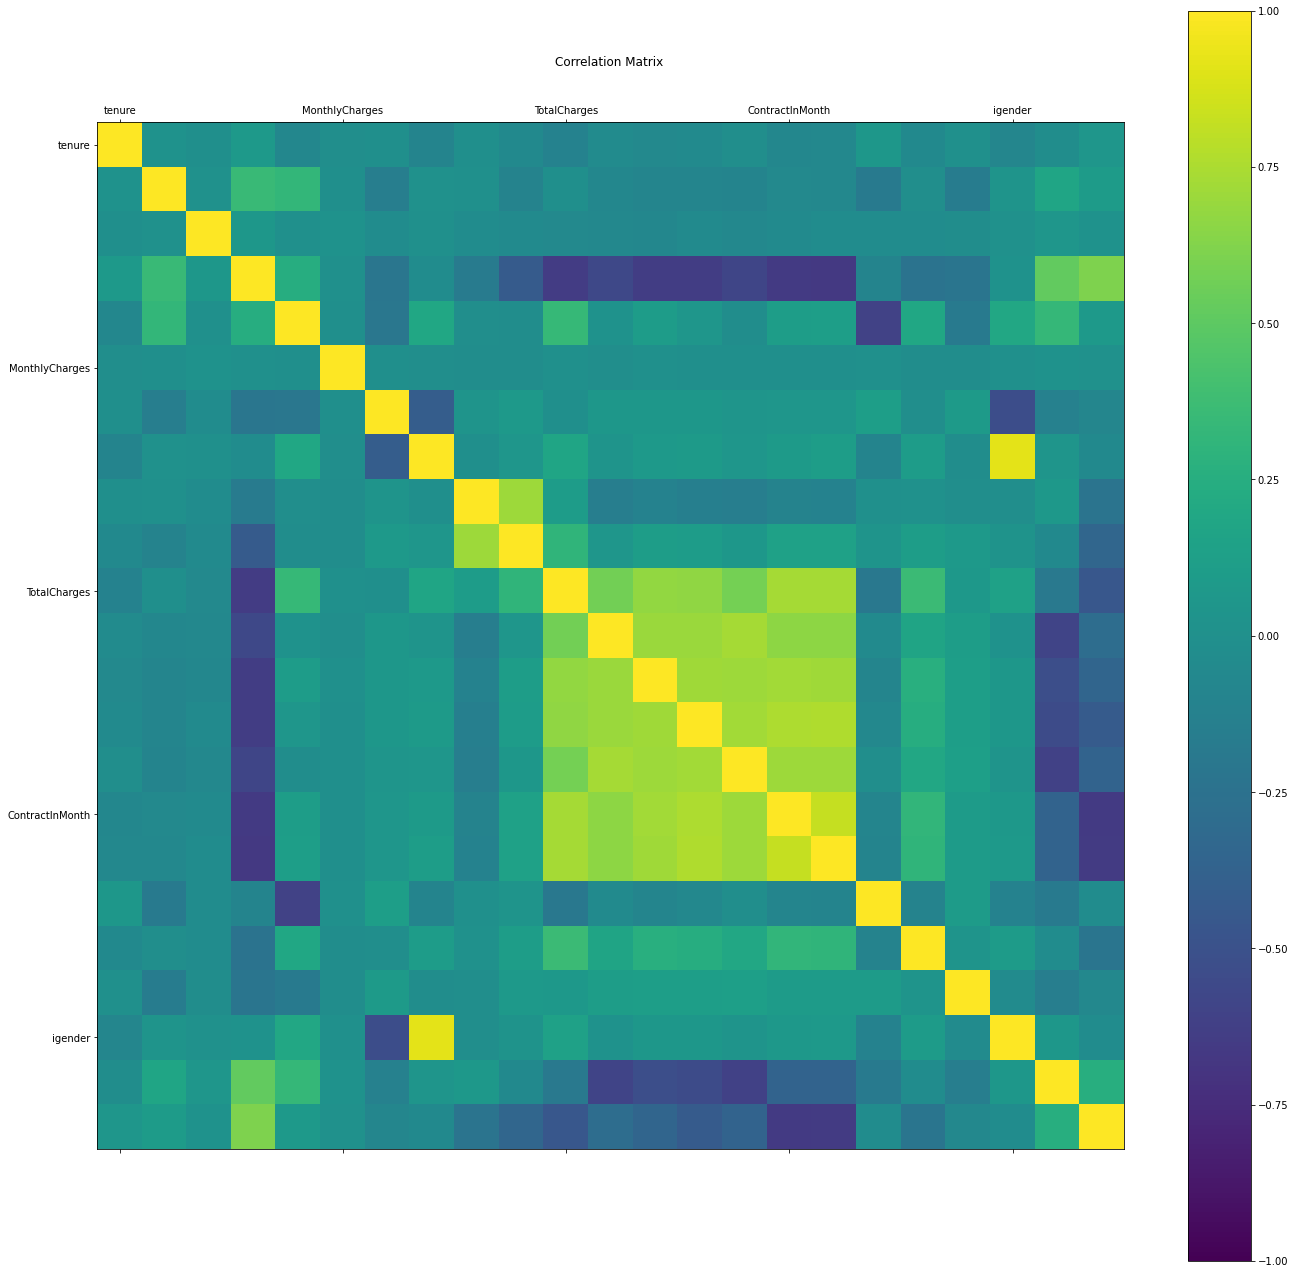

In [78]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(len(all_features),len(all_features)))
ax=fig.add_subplot(1,1,1)
ax.set_title("Correlation Matrix ")
ax.set_xticks(np.arange(len(all_features)))
ax.set_yticks(np.arange(len(all_features)))
ax.set_xticklabels(all_features)
ax.set_yticklabels(all_features)
cax=ax.matshow(pearsonCorrOnFEdataset,vmax=1,vmin=-1)
fig.colorbar(cax)
plt.show()



**MEthod 1:**

In [85]:
from pyspark.ml.classification import LogisticRegression

(training_data, test_data) = af_transformed_dataset.randomSplit([0.8,0.2])
print('Training Dataset Count: ' , training_data.count())
print('Training Dataset Count: ' , test_data.count())

lrOnFE1=LogisticRegression(featuresCol='AllFeatures',labelCol='iLabel',maxIter=10)
lrOnFE1Model=lrOnFE1.fit(training_data)
FE1Predictions=lrOnFE1Model.transform(test_data)
FE1Predictions.show()
FE1Predictions.select(FE1Predictions["rawPrediction"],FE1Predictions["probability"],FE1Predictions["prediction"]).show(truncate=False)


Training Dataset Count:  183901
Training Dataset Count:  46089


In [21]:
FE1accuracy = FE1Predictions.filter(FE1Predictions.iLabel == FE1Predictions.prediction).count() / float(FE1Predictions.count())
print("Accuracy : ",FE1accuracy)

Accuracy :  0.8669487847222223


**Method 2:**

In [ ]:
from pyspark.ml.stat import Correlation
selectedFeatureDataset = dataset
for col in selectedFeatureDataset.columns:
  if(col!="customerID" and col !="AllFeatures"):
        corr=selectedFeatureDataset.stat.corr(col, "iLabel")
        print("\n\n",col,"feature correlation width customer churn var: ",corr)
        if(corr<0.1 and corr>-0.1):
            selectedFeatureDataset=selectedFeatureDataset.drop(col)
selectedFeatureDataset.show()
#pearsonCorrOnFEdataset = Correlation.corr(af_transformed_dataset, 'AllFeatures', 'pearson').collect()[0][0]
#print(str(pearsonCorrOnFEdataset))
#af_transformed_dataset.show(truncate=0)


In [104]:
from pyspark.ml.feature import VectorAssembler
m2dataset=dataset
m2dataset=m2dataset.drop("ihighDependents")
m2dataset=m2dataset.drop("iOnlineSecurity")
m2dataset=m2dataset.drop("iOnlineBackup")
m2dataset=m2dataset.drop("iDeviceProtection")
m2dataset=m2dataset.drop("iTechSupport")
m2dataset.show()
all_features=['SeniorCitizen','tenure','MonthlyCharges','TotalCharges','ContractInMonth','igender','iPartner','iDependents','iPhoneService','iMultipleLines','iInternetService','iStreamingTV','iStreamingMovies','iContract','iPaperlessBilling','iPaymentMethod','iCautious','iFullTech']
all_features_assembler = VectorAssembler(inputCols=all_features, outputCol='AllFeatures')
af_transformed_datasetm2 = all_features_assembler.transform(m2dataset)
af_transformed_datasetm2.select(af_transformed_datasetm2["AllFeatures"]).show(truncate=False)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------+--------+--------+---------------+-------+--------+-----------+-------------+--------------+----------------+------------+----------------+---------+-----------------+--------------+---------+---------+------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|highDependents|Cautious|FullTech|ContractInMonth|igender|iPartner|iDependents|iPhoneService|iMultipleLines|iInternetService|iStreamingTV|iStreamingMovi

In [105]:
from pyspark.ml.classification import LogisticRegression

(training_data, test_data) = af_transformed_datasetm2.randomSplit([0.8,0.2])
print('Training Dataset Count: ' , training_data.count())
print('Training Dataset Count: ' , test_data.count())

lrOnFE2=LogisticRegression(featuresCol='AllFeatures',labelCol='iLabel',maxIter=10)
lrOnFE2Model=lrOnFE2.fit(training_data)
FE2Predictions=lrOnFE2Model.transform(test_data)
FE2Predictions.show()
FE2Predictions.select(FE2Predictions["rawPrediction"],FE2Predictions["probability"],FE2Predictions["prediction"]).show(truncate=False)


Training Dataset Count:  183863
Training Dataset Count:  46127
+----------+------+-------------+-------+----------+-----------------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------------+------------------+-----+--------------+--------+--------+---------------+-------+--------+-----------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+---------+-----------------+--------------+---------------+---------+---------+------+--------------------+--------------------+--------------------+----------+
|customerID|gender|SeniorCitizen|Partner|Dependents|           tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    Streamin

In [106]:
FE2accuracy = FE2Predictions.filter(FE2Predictions.iLabel == FE2Predictions.prediction).count() / float(FE2Predictions.count())
print("Accuracy : ",FE2accuracy)

Accuracy :  0.866130465887658


**Method 3:**

In [111]:
dataset.show()
from pyspark.ml.stat import Correlation
selectedFeatureDataset = dataset
for col in selectedFeatureDataset.columns:
  if(col!="customerID" and col !="AllFeatures"):
        corr=selectedFeatureDataset.stat.corr(col, "iLabel")
        print("\n\n",col,"feature correlation width customer churn var: ",corr)
        if(corr<0.1 and corr>-0.1):
            selectedFeatureDataset=selectedFeatureDataset.drop(col)
selectedFeatureDataset.show()

+----------+-------------+------+--------------+------------+---------------+-------+--------+-----------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+---------+-----------------+--------------+---------------+---------+---------+------+
|customerID|SeniorCitizen|tenure|MonthlyCharges|TotalCharges|ContractInMonth|igender|iPartner|iDependents|iPhoneService|iMultipleLines|iInternetService|iOnlineSecurity|iOnlineBackup|iDeviceProtection|iTechSupport|iStreamingTV|iStreamingMovies|iContract|iPaperlessBilling|iPaymentMethod|ihighDependents|iCautious|iFullTech|iLabel|
+----------+-------------+------+--------------+------------+---------------+-------+--------+-----------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+---------+-----------------+--------------+---------------+---------+---------+------+
|5331-RGMT

In [121]:
all_features=['tenure','ContractInMonth','iDependents','iInternetService','iStreamingTV','iStreamingMovies','iContract','iPaperlessBilling','ihighDependents','iCautious','iFullTech']
selectedFeatureDataset=selectedFeatureDataset.drop('AllFeatures')
all_features_assembler = VectorAssembler(inputCols=all_features, outputCol='AllFeatures')
af_transformed_datasetm3 = all_features_assembler.transform(selectedFeatureDataset)
af_transformed_datasetm3.select(af_transformed_datasetm3["AllFeatures"]).show(truncate=False)

+-----------------------------------------------+
|AllFeatures                                    |
+-----------------------------------------------+
|(11,[0,1,6,10],[54.0,1.0,1.0,1.0])             |
|(11,[0,1,5,7],[37.0,24.0,1.0,1.0])             |
|(11,[0,1,3,5,7,9],[72.0,24.0,1.0,1.0,1.0,1.0]) |
|(11,[0,1,3,4,5,6],[8.0,1.0,1.0,1.0,1.0,1.0])   |
|[66.0,12.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0]|
|[72.0,24.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0]|
|[62.0,24.0,1.0,2.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0]|
|[68.0,24.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0]|
|(11,[0,1,3,4,5],[72.0,24.0,2.0,2.0,2.0])       |
|[69.0,24.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0]|
|(11,[0,1,5,6],[34.0,1.0,1.0,1.0])              |
|[52.0,24.0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0]|
|(11,[0,1,4,5,9],[70.0,24.0,1.0,1.0,1.0])       |
|[55.0,12.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0]|
|(11,[0,1,3,4,5],[63.0,24.0,2.0,2.0,2.0])       |
|(11,[0,1,2,9,10],[70.0,24.0,1.0,1.0,1.0])      |
|(11,[0,1,4,6,7],[61.0,1.0,1.0,1.0,1.0])        |


In [122]:
(training_data, test_data) = af_transformed_datasetm3.randomSplit([0.8,0.2])
print('Training Dataset Count: ' , training_data.count())
print('Training Dataset Count: ' , test_data.count())

lrOnFE3=LogisticRegression(featuresCol='AllFeatures',labelCol='iLabel',maxIter=10)
lrOnFE3Model=lrOnFE3.fit(training_data)
FE3Predictions=lrOnFE3Model.transform(test_data)
FE3Predictions.show()
FE3Predictions.select(FE3Predictions["rawPrediction"],FE3Predictions["probability"],FE3Predictions["prediction"]).show(truncate=False)

Training Dataset Count:  184131
Training Dataset Count:  45859
+----------+-----------------+---------------+-----------+----------------+------------+----------------+---------+-----------------+---------------+---------+---------+------+--------------------+--------------------+--------------------+----------+
|customerID|           tenure|ContractInMonth|iDependents|iInternetService|iStreamingTV|iStreamingMovies|iContract|iPaperlessBilling|ihighDependents|iCautious|iFullTech|iLabel|         AllFeatures|       rawPrediction|         probability|prediction|
+----------+-----------------+---------------+-----------+----------------+------------+----------------+---------+-----------------+---------------+---------+---------+------+--------------------+--------------------+--------------------+----------+
|      null|              2.0|             24|        0.0|             1.0|         1.0|             1.0|      0.0|              1.0|            0.0|      0.0|      0.0|   1.0|(11,[0,1

In [123]:
FE3accuracy = FE3Predictions.filter(FE3Predictions.iLabel == FE3Predictions.prediction).count() / float(FE3Predictions.count())
print("Accuracy : ",FE3accuracy)

Accuracy :  0.8554918336640572


**Method 4:**

In [120]:
raw_data_withoutMV.show()
from pyspark.ml.feature import StringIndexer
all_cat_col_list=['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Label']
for col in all_cat_col_list:
  outCol='i'+col
  raw_data_withoutMV=raw_data_withoutMV.drop(outCol)
  raw_data_withoutMV = StringIndexer(inputCol=col,outputCol=outCol,handleInvalid='keep').fit(raw_data_withoutMV).transform(raw_data_withoutMV)

raw_data_withoutMV.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------+--------+-----------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+---------+-----------------+--------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|igender|iPartner|iDependents|iPhoneService|iMultipleLines|iInternetService|iOnlineSecurity|iOnlineBackup|iDeviceProtection|iTechSupport|iStreamingTV|iStreamingMovies|

In [125]:
all_features=['SeniorCitizen','tenure','MonthlyCharges','TotalCharges','igender','iPartner','iDependents','iPhoneService','iMultipleLines','iInternetService','iOnlineSecurity','iOnlineBackup','iDeviceProtection','iTechSupport','iStreamingTV','iStreamingMovies','iContract','iPaperlessBilling','iPaymentMethod']
all_features_assembler = VectorAssembler(inputCols=all_features, outputCol='AllFeatures')
af_transformed_datasetm4 = all_features_assembler.transform(raw_data_withoutMV)
af_transformed_datasetm4.select(af_transformed_datasetm4["AllFeatures"]).show(truncate=False)

+--------------------------------------------------------------------------------------+
|AllFeatures                                                                           |
+--------------------------------------------------------------------------------------+
|(19,[0,1,2,3,10,11,13,16,18],[1.0,54.0,99.05,5295.7,1.0,1.0,1.0,1.0,1.0])             |
|(19,[1,2,3,10,11,15,17,18],[37.0,94.3,3460.95,1.0,1.0,1.0,1.0,3.0])                   |
|(19,[0,1,2,3,8,9,15,17],[1.0,72.0,74.4,5360.75,1.0,1.0,1.0,1.0])                      |
|(19,[1,2,3,8,9,10,12,13,14,15,16],[8.0,49.55,393.45,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|(19,[0,1,2,3,6,10,16,18],[1.0,66.0,108.45,7076.35,1.0,1.0,2.0,2.0])                   |
|(19,[1,2,3,4,6,11,17,18],[72.0,107.45,7576.7,1.0,1.0,1.0,1.0,3.0])                    |
|(19,[1,2,3,6,9,10,11,12,13,14,15],[62.0,24.25,1424.6,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0])|
|(19,[1,2,3,4,6,7,8,9,10,17,18],[68.0,60.3,4109.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0])    |
|(19,[1,2,3,9,10,11,1

In [126]:
(training_data, test_data) = af_transformed_datasetm4.randomSplit([0.8,0.2])
print('Training Dataset Count: ' , training_data.count())
print('Training Dataset Count: ' , test_data.count())

lrOnFE4=LogisticRegression(featuresCol='AllFeatures',labelCol='iLabel',maxIter=10)
lrOnFE4Model=lrOnFE4.fit(training_data)
FE4Predictions=lrOnFE4Model.transform(test_data)
FE4Predictions.show()
FE4Predictions.select(FE4Predictions["rawPrediction"],FE4Predictions["probability"],FE4Predictions["prediction"]).show(truncate=False)

Training Dataset Count:  183273
Training Dataset Count:  45917
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------+--------+-----------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+---------+-----------------+--------------+------+--------------------+--------------------+--------------------+----------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|igender|iPartner|iDependents|iPhoneService|iMultipleLines|iInternetService|iOnlineSecurity|iOnline

In [127]:
FE4accuracy = FE4Predictions.filter(FE4Predictions.iLabel == FE4Predictions.prediction).count() / float(FE4Predictions.count())
print("Accuracy : ",FE4accuracy)

Accuracy :  0.8632314828930462
